In [2]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from fuzzywuzzy import fuzz
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Embedding, LSTM,Dropout,Bidirectional,GlobalMaxPooling1D

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [1]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# load dataset

In [62]:
data = pd.read_excel('Bot Dataset(fixed).xlsx')
data.tail()

,tag,Question,Answer
433,user 446,mati saja,Mengakhiri hidup adalah bukan suatu pilihan ya...
434,user 447,Apa itu Temara,Temara adalah aplikasi yang bisa menjadi teman...
435,user 448,Temara,Temara adalah aplikasi yang bisa menjadi teman...
436,user 449,Halo,Hai!
437,user 450,Hai!,Hallo!


# inisialisasi stop words

In [63]:
stopwords = []
with open('stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

In [64]:
# fungsi untuk menghilangkan stopwords
def remove_stopwords(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    temp = re.sub(r'[.,’"\'-?:!;]', '', text)
    text = re.sub(r'^Apa|^Saya|^Aku|^maukah|^Siapa|^Bagaimana|^Dimana|^Kapan|^Kenapa|^Bisakah', '', text)
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words)

In [65]:
# menghilangkan stopwords dari dataset
data['Question'] = data['Question'].apply(remove_stopwords)
print(data['Question'])

0                             penyakit mental
1                mempengaruhi penyakit mental
2                 menyebabkan penyakit mental
3      tanda tanda peringatan penyakit mental
4                 orang penyakit mental pulih
                        ...                  
433                                      mati
434                                    temara
435                                    temara
436                                      halo
437                                       hai
Name: Question, Length: 438, dtype: object


# inisialisasi tokenizer

In [66]:
# inisialisasi tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['Question'])

In [67]:
# fungsi untuk mengganti kata typo dengan kata yang paling mirip pada dataset
def correct_typo(word):
    max_score = -1
    correct_word = word
    for vocab_word in tokenizer.word_index:
        score = fuzz.ratio(word, vocab_word)
        if score > max_score:
            max_score = score
            correct_word = vocab_word
    return correct_word

# fungsi untuk mengoreksi typo pada kalimat
def correct_sentence(sentence):
    corrected_sentence = []
    words = sentence.split()
    for word in words:
        corrected_word = correct_typo(word)
        corrected_sentence.append(corrected_word)
    return ' '.join(corrected_sentence)

# fungsi untuk membersihkan dan memproses input pengguna
def preprocess_input(text):
    text = remove_stopwords(text)
    text = correct_sentence(text)
    return text


# encoding label Respon

In [68]:
encoder = LabelEncoder()
encoder.fit(data['Answer'])
encoded_labels = encoder.transform(data['Answer'])

# split data menjadi train dan validation set

In [69]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
val_data = data[train_size:]

train_seq = tokenizer.texts_to_sequences(data['Question'])
val_seq = tokenizer.texts_to_sequences(val_data['Question'])

train_label_seq = encoded_labels[:train_size]
val_label_seq = encoded_labels[train_size:]

# padding sequence

In [70]:
train_seq = pad_sequences(train_seq, maxlen=100, truncating='post')
val_seq = pad_sequences(val_seq, maxlen=100, truncating='post')

# callback

In [71]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.998:
            print("\n\nAccuracy Has Been Achieved Around 99.8%, Training Stop!\n")
            self.model.stop_training = True

# MODEL

In [72]:
model = Sequential([
    Embedding(len(tokenizer.word_index)+1, 64, input_length=100),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(450, activation='softmax')
])
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [73]:
# training model
history = model.fit(train_seq, encoded_labels, epochs=200,callbacks=[Callback()])

Epoch 1/200
14/14 [==============================] - 8s 240ms/step - loss: 6.1142 - accuracy: 0.0023
Epoch 2/200
14/14 [==============================] - 5s 338ms/step - loss: 6.1064 - accuracy: 0.0114
Epoch 3/200
14/14 [==============================] - 3s 236ms/step - loss: 6.0972 - accuracy: 0.0114
Epoch 4/200
14/14 [==============================] - 3s 234ms/step - loss: 6.0775 - accuracy: 0.0137
Epoch 5/200
14/14 [==============================] - 4s 304ms/step - loss: 6.0209 - accuracy: 0.0091
Epoch 6/200
14/14 [==============================] - 4s 260ms/step - loss: 5.9884 - accuracy: 0.0091
Epoch 7/200
14/14 [==============================] - 3s 239ms/step - loss: 5.9596 - accuracy: 0.0091
Epoch 8/200
14/14 [==============================] - 3s 237ms/step - loss: 5.9411 - accuracy: 0.0137
Epoch 9/200
14/14 [==============================] - 5s 338ms/step - loss: 5.9025 - accuracy: 0.0205
Epoch 10/200
14/14 [==============================] - 3s 233ms/step - loss: 5.8565 - accura

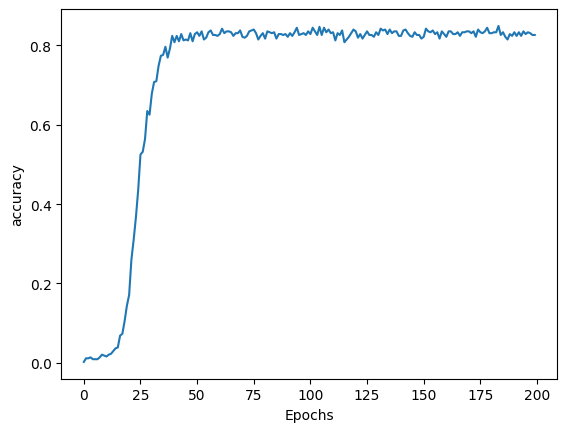

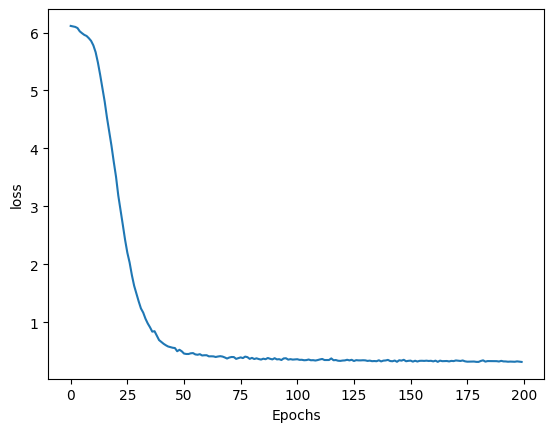

In [74]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# TESTING

In [90]:

try:
    input_text = input('Masukkan pertanyaan: ')
    preprocessed_text = preprocess_input(input_text)
    input_seq = tokenizer.texts_to_sequences([preprocessed_text])
    input_seq = pad_sequences(input_seq, maxlen=100)
    predicted_label_seq = model.predict(input_seq)
    predicted_label = encoder.inverse_transform(predicted_label_seq.argmax(axis=-1))[0]
    print('Bot: ', predicted_label)
except:
    print("Bot : maaf saya tidak memahami maksud anda")

Masukkan pertanyaan: saya pikir saya jelek
1/1 [==============================] - 0s 31ms/step
Bot:  Nah, apakah Anda benar-benar berpikir begitu? Apakah Anda ingin melihat wajah paling cantik yang pernah ada? Buka WebCam Anda dan voila, wajah tercantik di planet ini muncul secara ajaib.


# save model

In [96]:
model.save("model.h5")

In [95]:

import pickle
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('label_encoder.pickle', 'wb') as f:
     pickle.dump(encoder, f, protocol=pickle.HIGHEST_PROTOCOL)